# EDA and Feature Engineering

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import branca.colormap as cm
# Rename to eda_iriginal_dataset c'est pas le fichier des modèles cleui là

# I. EDA of Original Dataset

In [2]:
data = pd.read_parquet("/Users/solalzana/Desktop/X/Python for Data Science/Final Project/bike_counters/data/train.parquet")
data.describe()

,site_id,bike_count,date,counter_installation_date,latitude,longitude,log_bike_count
count,4.968270e+05,496827.000000,496827,496827,496827.000000,496827.000000,496827.000000
mean,1.053450e+08,60.191475,2021-03-08 07:25:59.668858,2019-04-04 07:24:35.245911,48.854343,2.345479,3.079917
min,1.000070e+08,0.000000,2020-09-01 01:00:00,2013-01-18 00:00:00,48.826360,2.265420,0.000000
25%,1.000475e+08,5.000000,2020-12-05 22:00:00,2018-11-29 00:00:00,48.840801,2.314440,1.791759
50%,1.000562e+08,29.000000,2021-03-08 11:00:00,2019-11-06 00:00:00,48.852090,2.353870,3.401197
75%,1.000563e+08,79.000000,2021-06-09 14:00:00,2019-12-11 00:00:00,48.864610,2.375870,4.382027
max,3.000147e+08,1302.000000,2021-09-09 23:00:00,2020-11-29 00:00:00,48.891720,2.409690,7.172425
std,3.210346e+07,87.590566,NaN,NaN,0.018554,0.038026,1.659899


In [3]:
# Ensure the DataFrame is sorted by date
data = data.sort_values("date")

# Create a boolean column for bike_count == 0
data["is_zero"] = data["bike_count"] == 0

# Create a group identifier for consecutive streaks of bike_count != 0
data["group"] = (data["is_zero"] != data["is_zero"].shift()).cumsum()

# Filter groups where bike_count == 0 and count the streaks
consecutive_zeros = (
    data[data["is_zero"]]
    .groupby("group")
    .filter(lambda x: len(x) >= 100)
)

# Display the result
print(consecutive_zeros)

Empty DataFrame
Columns: [counter_id, counter_name, site_id, site_name, bike_count, date, counter_installation_date, coordinates, counter_technical_id, latitude, longitude, log_bike_count, is_zero, group]
Index: []


In [4]:
data.nunique(axis=0)

counter_id                      56
counter_name                    56
site_id                         30
site_name                       30
bike_count                     998
date                          8974
counter_installation_date       22
coordinates                     30
counter_technical_id            30
latitude                        30
longitude                       30
log_bike_count                 998
is_zero                          2
group                        57339
dtype: int64

In [5]:
# Check for missing values
data.isnull().sum() # no missing values

counter_id                   0
counter_name                 0
site_id                      0
site_name                    0
bike_count                   0
date                         0
counter_installation_date    0
coordinates                  0
counter_technical_id         0
latitude                     0
longitude                    0
log_bike_count               0
is_zero                      0
group                        0
dtype: int64

In [6]:
# def date_encoder(X, col="date"):
#     X = X.copy()  # modify a copy of X
#     X[col] = pd.to_datetime(X[col])

#     # Encode the date information from the date column
#     X["year"] = X[col].dt.year
#     X["quarter"] = X[col].dt.quarter
#     X["month"] = X[col].dt.month
#     X["day"] = X[col].dt.day
#     X["weekday"] = X[col].dt.weekday + 1
#     X["hour"] = X[col].dt.hour

#     # Once we did the encoding, we can drop the original column
#     X = X.drop(col, axis=1)
#     return X

# date_encoder(data, col="date")
# # data.set_index(data["date"], inplace=True)

# # Also drop redundant columns
# data.drop(columns=["counter_id", "site_id", "counter_installation_date", "counter_technical_id", "coordinates"], axis=1, inplace=True)
# data

Now, let's plot the data to have a general idea of its distribution.

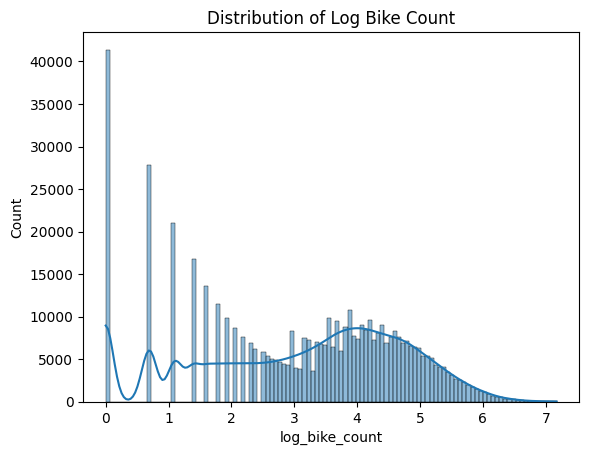

In [7]:
# target variable distribution
sns.histplot(data['log_bike_count'], kde=True) # using the log as bike_count is skewed
plt.title('Distribution of Log Bike Count')
plt.show()

In [8]:
# # Daily average log bike count
# data['log_bike_count'].resample('D').mean().plot(title='Daily Average Log Bike Count')
# plt.show()

Kind of normally distrbuted...

/var/folders/1q/4p_js9jn14x3_527d5fmd8dr0000gn/T/ipykernel_8746/3846441962.py:8: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  data[mask].groupby(["counter_name", pd.Grouper(freq="1w", key="date")], observed = True)["bike_count"].sum().unstack(0).plot(figsize = (12,6), ylabel='log_bike_count')


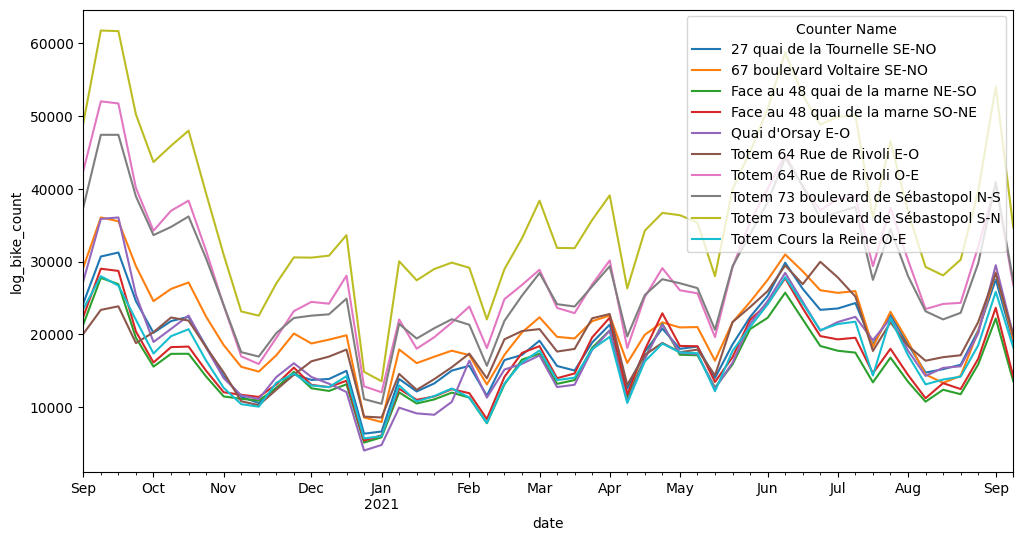

In [9]:
# Find the top 10 counters by total bike count
top_counters = data.groupby("counter_name", observed = True)["bike_count"].sum().nlargest(10).index

# Create a mask for these top counters
mask = data["counter_name"].isin(top_counters)

# Group by week and plot
data[mask].groupby(["counter_name", pd.Grouper(freq="1w", key="date")], observed = True)["bike_count"].sum().unstack(0).plot(figsize = (12,6), ylabel='log_bike_count')
plt.legend(title='Counter Name', bbox_to_anchor=(1, 1), loc="upper right")

At first sight, we can see a correlation between the usage and time of the year (more specifically less use during winter and more during summer). We can also see that some counters are consistently used more than others, maybe because of their location (more traffic in some zones of Paris, at the center maybe?), we will check that later.

In [10]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

/var/folders/1q/4p_js9jn14x3_527d5fmd8dr0000gn/T/ipykernel_8746/1192055722.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"].sum()


,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,984914.0
Quai d'Orsay,Quai d'Orsay E-O,948357.0
Totem Cours la Reine,Totem Cours la Reine O-E,894937.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,884907.0


The most used counter (73 boulevard de Sébastopol) is very close to the center of Paris. Maybe there is more traffic at the center of Paris than at the extremities, let's check that.

# ÇA MARCHE PREQUE DISTANCE DU CENTRE!

In [11]:
# import folium
# from folium.plugins import MarkerCluster
# import branca.colormap as cm

# # Create a Folium map centered in Paris (we took online coordinates for 'center of Paris')
# m = folium.Map(location=[48.8566, 2.3522], zoom_start=12)

# # create colormap gradient base don bike count
# colormap = cm.LinearColormap(
#     colors=["green", "yellow", "red"],  # Gradient from green to red
#     vmin=data['bike_count'].min(),
#     vmax=data['bike_count'].max()
# )

# marker_cluster = MarkerCluster().add_to(m)

# # Add markers for each bike counter
# for latitude, longitude, bike_count, site_name in zip(data['latitude'], data['longitude'], data['bike_count'], data['site_name']):
#     folium.CircleMarker(
#         location=[latitude, longitude],
#         radius=10,
#         color=None,
#         fill=True,
#         fill_color=colormap(bike_count),
#         fill_opacity=0.8,
#         popup=folium.Popup(f"{site_name}<br>Bikes: {bike_count}", max_width=300)
#     ).add_to(marker_cluster)

# # colormap.caption = "Bike Counts"
# marker_cluster.save("bike_map.html")

In [12]:
data["date"].min(), data["date"].max()

(Timestamp('2020-09-01 01:00:00'), Timestamp('2021-09-09 23:00:00'))

We also notice that dates coincide with the covid era. Upon further research we see that there has been 2 quarantines so we implement them.

In [13]:
data["quarantine1"] = np.where((data['date'] >= '2020-10-30') & (data['date'] <= '2020-12-14'), 1, 0)
data["quarantine2"] = np.where((data['date'] >= '2020-04-03') & (data['date'] <= '2020-05-02'), 1, 0)

We are checking our weather/season hypothesis in the eda_external file where we explore the given dataset about meteorological conditions. We will merge both cleaned dataset for better understanding.

# II. ADDING ADDITIONAL DATASETS

## 1. Given weather data

In [14]:
df_ext = pd.read_csv("/Users/solalzana/Desktop/X/Python for Data Science/Final Project/bike_counters/external_data/external_data.csv")
df_ext

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,7149,2020-09-30 09:00:00,101540,-30,8,230,4.4,289.95,286.85,82,...,400.0,7.0,6.0,2200.0,NaN,NaN,NaN,NaN,NaN,NaN
3318,7149,2020-09-30 12:00:00,101320,-210,8,190,4.9,292.05,285.55,66,...,870.0,7.0,6.0,1900.0,NaN,NaN,NaN,NaN,NaN,NaN
3319,7149,2020-09-30 15:00:00,101140,-180,7,190,4.1,291.55,286.45,72,...,820.0,7.0,6.0,2200.0,NaN,NaN,NaN,NaN,NaN,NaN
3320,7149,2020-09-30 18:00:00,101020,-130,6,190,2.7,290.15,285.25,73,...,2160.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Missing values

In [15]:
# Check for missing values
df_ext.isnull().sum()
# Better to check the proportion of missing values relative to the total nb of obs
df_ext.isnull().sum() / len(df_ext)

numer_sta    0.000000
date         0.000000
pmer         0.000000
tend         0.000000
cod_tend     0.000000
dd           0.000000
ff           0.000000
t            0.000000
td           0.000000
u            0.000000
vv           0.000000
ww           0.000000
w1           0.002107
w2           0.003010
n            0.046960
nbas         0.001505
hbas         0.136364
cl           0.124323
cm           0.415713
ch           0.494883
pres         0.000000
niv_bar      1.000000
geop         1.000000
tend24       0.003010
tn12         0.750151
tn24         1.000000
tx12         0.750151
tx24         1.000000
tminsol      0.999699
sw           1.000000
tw           1.000000
raf10        0.003010
rafper       0.000000
per          0.000000
etat_sol     0.015653
ht_neige     0.014750
ssfrai       0.133955
perssfrai    0.133955
rr1          0.002709
rr3          0.001806
rr6          0.004816
rr12         0.006623
rr24         0.007225
phenspe1     1.000000
phenspe2     1.000000
phenspe3  

Many columns have a ton of missing values, for that let's forget all those who have more than 10% of their values missing as they are not very reliable.

In [16]:
df_ext.drop(columns=df_ext.columns[(df_ext.isnull().sum()/len(df_ext)) >= 0.1], inplace=True)

Now, we have to replace missing values from the remaining columlns as some models like Random Forest can't work with them. We will replace them with the median to avoid sensitivity to outliers as there are many outliers in this dataset.

In [17]:
for col in df_ext.columns:
    if col != 'date':  # Exclude the 'date' column
        df_ext[col] = df_ext[col].fillna(df_ext[col].median())

In [18]:
df_ext.isnull().sum()

numer_sta    0
date         0
pmer         0
tend         0
cod_tend     0
dd           0
ff           0
t            0
td           0
u            0
vv           0
ww           0
w1           0
w2           0
n            0
nbas         0
pres         0
tend24       0
raf10        0
rafper       0
per          0
etat_sol     0
ht_neige     0
rr1          0
rr3          0
rr6          0
rr12         0
rr24         0
dtype: int64

In [19]:
df_ext.nunique(axis=0)

numer_sta       1
date         3321
pmer          465
tend           99
cod_tend        9
dd             37
ff            109
t             345
td            281
u              77
vv           1230
ww             42
w1              9
w2              9
n              10
nbas           10
pres          459
tend24        353
raf10         170
rafper        186
per             1
etat_sol        9
ht_neige        7
rr1            33
rr3            64
rr6            91
rr12          124
rr24          164
dtype: int64

We see that there is numerous empty columns, and that `numer_sta`, `tminsol`, and `per` only have a unique value, so they are irrelevant. 

In [20]:
df_ext.drop(columns=df_ext.columns[df_ext.nunique()==0], inplace=True)
df_ext.drop(columns=["numer_sta", "per"], inplace=True)

#### Checking for multicolinearity

<function matplotlib.pyplot.show(close=None, block=None)>

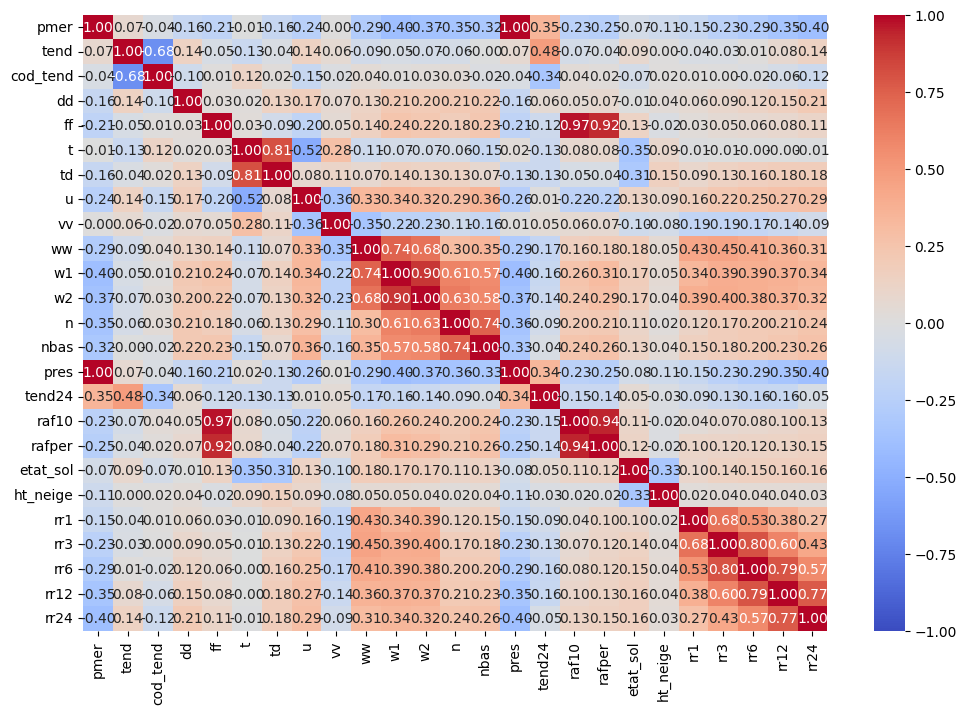

In [21]:
df_ext_wo_date = df_ext.drop(columns=['date'])
correlation_matrix = df_ext_wo_date.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.show

Filtering for variables that are highly correlated.

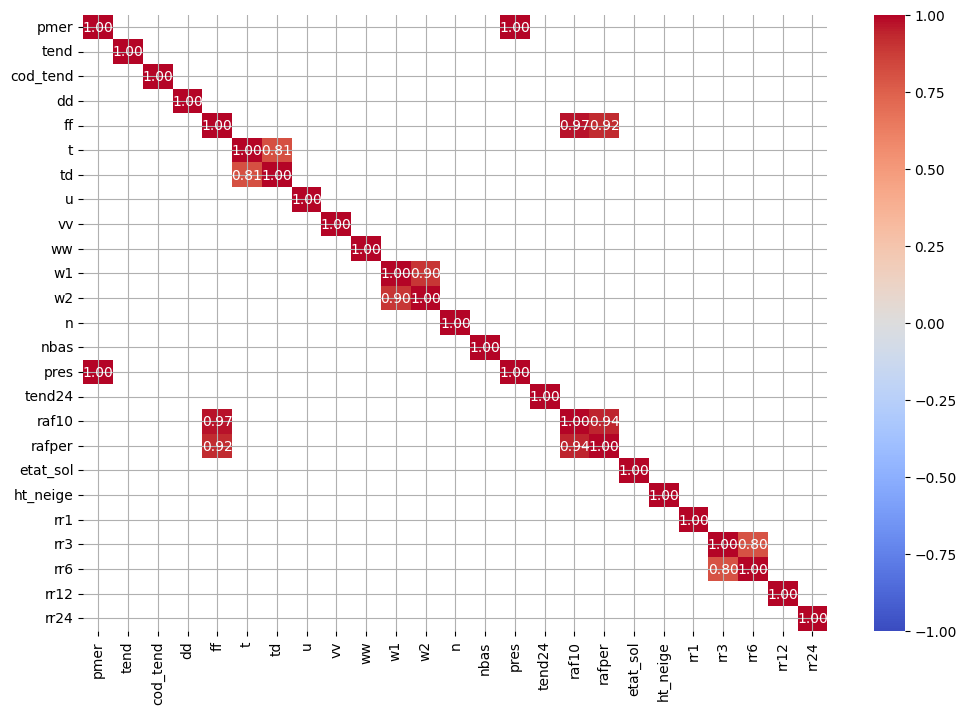

In [22]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[correlation_matrix.abs()>=0.8], annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.grid(True)

`pmer` and `pres` have a correlation of 1: we can keep one of both without losing any variance.
We can say the same for `raf10`and `rafper` and keep only windspeed `ff`. Following that logic we also drop `td` and `w2`.

In [23]:
df_ext.drop(columns=["pres", "raf10", "rafper", "td", "w2"], inplace=True)

We see that we can keep over 98% of the variance only keeping one component, thus this dataset may not be very significative.

#### Merging both cleaned datasets

In [24]:
# Convert both date columns to the same precision
data["date"] = data["date"].astype('datetime64[us]')
df_ext["date"] = df_ext["date"].astype('datetime64[us]')

# Merge both datasets
df_merged = pd.merge_asof(data.sort_values("date"), df_ext.sort_values("date"), on="date")
df_merged

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,...,n,nbas,tend24,etat_sol,ht_neige,rr1,rr3,rr6,rr12,rr24
0,100007049-101007049,28 boulevard Diderot O-E,100007049,28 boulevard Diderot,1.0,2020-09-01 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100047547-103047547,6 rue Julia Bartet SO-NE,100047547,6 rue Julia Bartet,2.0,2020-09-01 01:00:00,2018-11-28,"48.82636,2.30303",Y2H18086323,48.826360,...,0.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100056047-SC,Pont de la Concorde S-N,100056047,Pont de la Concorde S-N,1.0,2020-09-01 01:00:00,2019-11-08,"48.86378,2.32003",Y2H19070356,48.863780,...,0.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100047547-104047547,6 rue Julia Bartet NE-SO,100047547,6 rue Julia Bartet,4.0,2020-09-01 01:00:00,2018-11-28,"48.82636,2.30303",Y2H18086323,48.826360,...,0.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100056223-SC,Pont des Invalides N-S,100056223,Pont des Invalides N-S,2.0,2020-09-01 01:00:00,2019-11-07,"48.86284,2.310345",Y2H19070365,48.862840,...,0.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496822,100056047-SC,Pont de la Concorde S-N,100056047,Pont de la Concorde S-N,24.0,2021-09-09 23:00:00,2019-11-08,"48.86378,2.32003",Y2H19070356,48.863780,...,50.0,3.0,140.0,1.0,0.0,0.0,0.0,0.6,0.6,1.8
496823,100056329-103056329,Pont Charles De Gaulle SO-NE,100056329,Pont Charles De Gaulle,10.0,2021-09-09 23:00:00,2019-12-12,"48.84223,2.36811",Y2H19070375,48.842230,...,50.0,3.0,140.0,1.0,0.0,0.0,0.0,0.6,0.6,1.8
496824,100056336-105056336,27 quai de la Tournelle SE-NO,100056336,27 quai de la Tournelle,53.0,2021-09-09 23:00:00,2019-11-14,"48.85013,2.35423",Y2H19070383,48.850130,...,50.0,3.0,140.0,1.0,0.0,0.0,0.0,0.6,0.6,1.8
496825,100056329-104056329,Pont Charles De Gaulle NE-SO,100056329,Pont Charles De Gaulle,13.0,2021-09-09 23:00:00,2019-12-12,"48.84223,2.36811",Y2H19070375,48.842230,...,50.0,3.0,140.0,1.0,0.0,0.0,0.0,0.6,0.6,1.8


## 2. Additional Data: Vacances Scholaires et Jours Feriés

In [25]:
!pip install vacances-scolaires-france
!pip install jours_feries_france
# !pip install chantiers-a-paris

chantiers = pd.read_parquet("/Users/solalzana/Desktop/X/Python for Data Science/Final Project/bike_counters/data/chantiers-a-paris.parquet")

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [26]:
from vacances_scolaires_france import SchoolHolidayDates
from jours_feries_france import JoursFeries

school_holidays = SchoolHolidayDates()
jours_feries = JoursFeries()

df_merged['holidays'] = df_merged.apply(
    lambda row: 1 if school_holidays.is_holiday_for_zone(row["date"].date(), 'C') else 0, axis=1
)

df_merged['jour_ferie'] = df_merged.apply(
    lambda row: 1 if jours_feries.is_bank_holiday(row["date"].date()) else 0, axis=1
)

KeyboardInterrupt: 

In [ ]:
df_merged.drop(columns=["bike_count"], inplace=True)

In [ ]:
train_cleaned = df_merged.to_parquet("/Users/solalzana/Desktop/X/Python for Data Science/Final Project/bike_counters/data/train_cleaned.parquet")

## Checking relationship of variables with target

In [ ]:
# col_list = df_merged.columns.tolist()

# for i in range(0, 40):
#     # Sélectionnez la colonne courante
#     x = df_merged.iloc[:, i]
    
#     # Sélectionnez la colonne "log_bike_count"
#     y = df_merged["log_bike_count"]
    
#     # Créez un DataFrame temporaire pour regrouper et calculer la moyenne
#     temp_df = pd.DataFrame({'x': x, 'y': y})
#     temp_df_grouped = temp_df.groupby('x').mean().reset_index()
    
#     # Créez un nuage de points avec les valeurs agrégées
#     plt.scatter(temp_df_grouped['x'], temp_df_grouped['y'])

#     # Ajoutez des labels et une légende
#     plt.figure(figsize=(4, 3))
#     plt.xlabel(col_list[i])
#     plt.ylabel('log_bike_count (Moyenne)')
#     plt.title(f'Relation entre {col_list[i]} et log_bike_count (Moyenne)')
 
#     # Affichez chaque sous-plot séparément
#     plt.show()

Explained Variance Ratio: [0.25567975 0.11492626 0.09842346 0.08246151 0.06998099 0.05532249
 0.04815758 0.03971539 0.03666597 0.03471779 0.03019814 0.02605677
 0.02402144 0.01830849 0.01484854 0.01433281 0.01270549 0.00976637
 0.00819923 0.00551153]
cumulative Explained Variance Ratio: [0.25567975 0.370606   0.46902946 0.55149098 0.62147196 0.67679446
 0.72495204 0.76466743 0.8013334  0.83605119 0.86624933 0.8923061
 0.91632754 0.93463603 0.94948457 0.96381738 0.97652287 0.98628924
 0.99448847 1.        ]
PCA results saved to /Users/solalzana/Desktop/X/Python for Data Science/Final Project/bike_counters/data/pca_results.csv


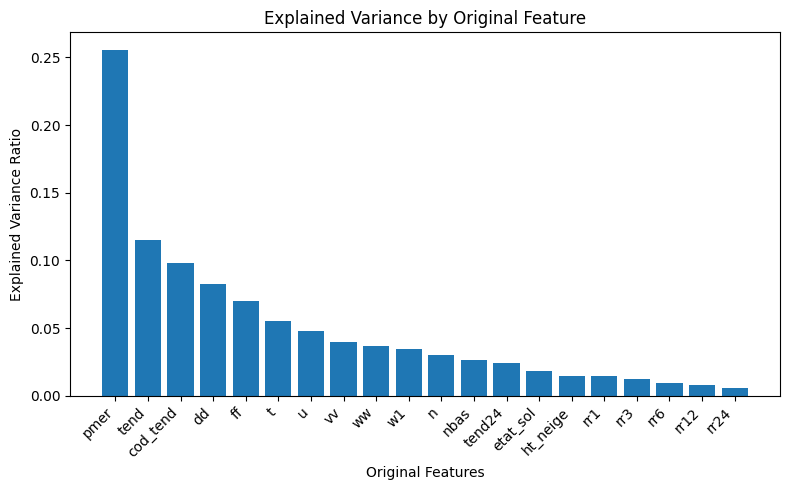

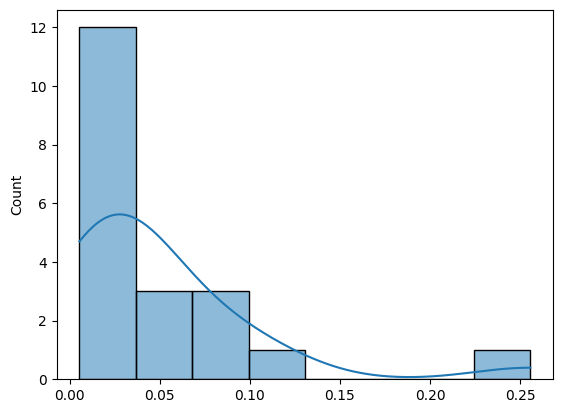

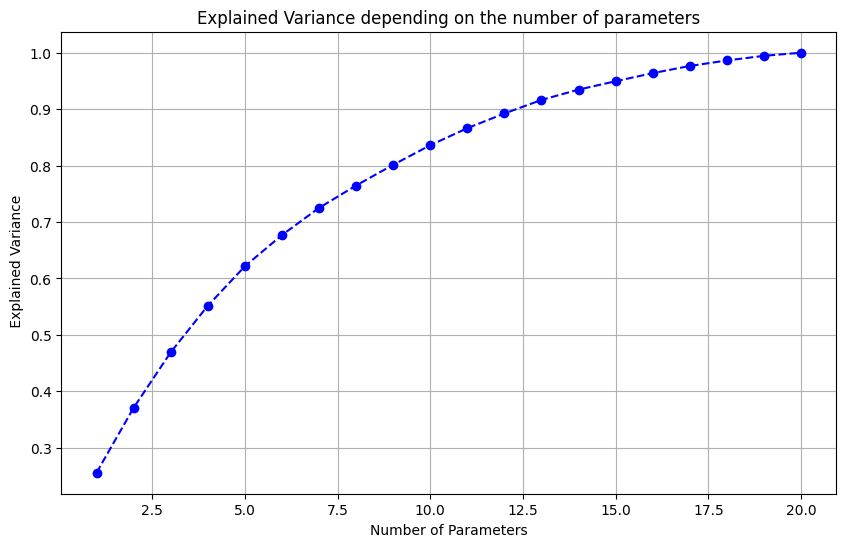

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
numeric_columns = df_ext.select_dtypes(include=['float64', 'int64']).columns
data_scaled = StandardScaler().fit_transform(df_ext[numeric_columns])
data_pca = pca.fit_transform(data_scaled)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(1, df_ext.shape[1])])

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Save the PCA results to a new file
output_path = "/Users/solalzana/Desktop/X/Python for Data Science/Final Project/bike_counters/data/pca_results.csv"
pca_df.to_csv(output_path, index=False)

cumulative_explained_variance = explained_variance.cumsum()

# Print the explained variance ratio
print("Explained Variance Ratio:", explained_variance)
print("cumulative Explained Variance Ratio:", cumulative_explained_variance)
print(f"PCA results saved to {output_path}")


plt.figure(figsize=(8, 5))
plt.bar(numeric_columns, explained_variance[:len(numeric_columns)])
plt.xlabel('Original Features')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Original Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

sns.histplot(explained_variance, kde=True)
# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
    linestyle="--",
    color="b",
)
plt.title("Explained Variance depending on the number of parameters")
plt.xlabel("Number of Parameters")
plt.ylabel(" Explained Variance")
plt.grid(True)
plt.show()

In [ ]:
df_merged.shape[0]

496827

In [ ]:
df_ext["ht_neige"].nunique()

7